In [3]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dsp import DSP

In [22]:
# --- CW Signal for TX (constant tone) ---
t = np.arange(4096) / 1e6
cw_signal = np.exp(1j * 2 * np.pi * 1e3 * t).astype(np.complex64)

c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


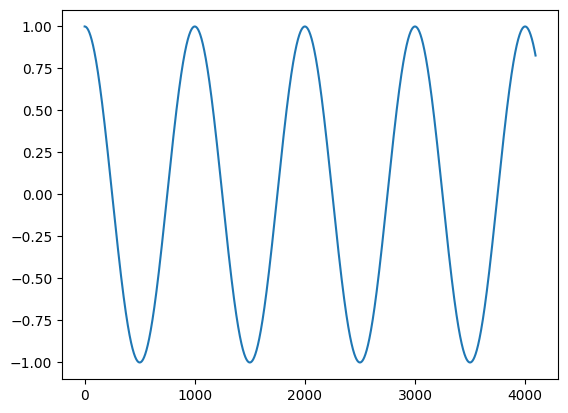

In [12]:
plt.plot(cw_signal)

In [2]:
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import adi
import time

# --- SDR Configuration ---
sdr = adi.Pluto("ip:192.168.2.1")

sample_rate = int(1e6)
center_freq = int(2.4e9)
buffer_length = 4096
sdr.sample_rate = sample_rate
sdr.rx_lo = center_freq
sdr.tx_lo = center_freq
sdr.tx_hardwaregain_chan0 = -10  # adjust to avoid RX overload
sdr.rx_hardwaregain_chan0 = 40
sdr.rx_buffer_size = buffer_length
sdr.gain_control_mode_chan0 = "manual"

# --- CW Signal for TX (constant tone) ---
t = np.arange(buffer_length) / sample_rate
cw_signal = np.exp(1j * 2 * np.pi * 0 * t).astype(np.complex64)
sdr.tx_cyclic_buffer = True
sdr.tx(cw_signal)

# --- LPF Helper ---
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass(data, cutoff=5.0, fs=sample_rate):
    b, a = butter_lowpass(cutoff, fs)
    return lfilter(b, a, data)

# --- Main Loop ---
print("Starting heart rate capture (press Ctrl+C to stop)...")

try:
    phase_buffer = []
    duration_sec = 20
    start_time = time.time()

    while time.time() - start_time < duration_sec:
        rx = sdr.rx()
        mixed = rx * np.conj(cw_signal[:len(rx)])
        phase = np.unwrap(np.angle(mixed))
        phase_buffer.extend(phase)

    # --- Process collected data ---
    phase_array = np.array(phase_buffer)
    phase_filtered = apply_lowpass(phase_array)

    # --- FFT ---
    N = len(phase_filtered)
    window = np.hanning(N)
    spectrum = np.fft.fft(phase_filtered * window)
    freqs = np.fft.fftfreq(N, 1 / sample_rate)

    # --- Limit to HR range ---
    mask = (freqs > 0.5) & (freqs < 3)
    peak_freq = freqs[mask][np.argmax(np.abs(spectrum[mask]))]
    bpm = peak_freq * 60

    # --- Plot ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(phase_filtered)
    plt.title("Filtered Phase Signal")
    plt.xlabel("Sample")
    plt.ylabel("Phase (rad)")

    plt.subplot(1, 2, 2)
    plt.plot(freqs[mask], 20 * np.log10(np.abs(spectrum[mask])))
    plt.title(f"Heart Rate Spectrum (Peak: {bpm:.2f} BPM)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.tight_layout()
    plt.show()

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    sdr.tx_destroy_buffer()
    del sdr


Starting heart rate capture (press Ctrl+C to stop)...
Stopped by user.


In [2]:
import sys
import time
import threading
import numpy as np
import scipy.constants
from scipy.signal import firwin, lfilter
from PyQt5.QtWidgets import QApplication, QMainWindow, QGridLayout, QWidget, QLabel, QCheckBox
from PyQt5 import QtCore
import pyqtgraph as pg
import adi

# === PlutoSDR Configuration ===
sdr = adi.Pluto(uri="ip:192.168.2.1")
sample_rate = int(1e6)
center_freq = int(2.4e9)
bw = 100e3
buffer_length = 4096

sdr.sample_rate = sample_rate
sdr.tx_lo = center_freq
sdr.rx_lo = center_freq
sdr.tx_hardwaregain_chan0 = -20
sdr.rx_hardwaregain_chan0 = 40
sdr.rx_buffer_size = buffer_length
sdr.gain_control_mode_chan0 = "manual"

# === Chirp Signal ===
duration = 500e-6
ts = 1 / sample_rate
N_chirp = int(duration * sample_rate)
t = np.arange(0, N_chirp * ts, ts)
f_start, f_stop = 0, bw
chirp = np.exp(1j * 2 * np.pi * (f_start * t + 0.5 * (f_stop - f_start) / duration * t**2)).astype(np.complex64)

chirp_padded = np.zeros(buffer_length, dtype=np.complex64)
chirp_padded[:len(chirp)] = chirp
chirp_conj = np.conj(chirp_padded)

slope = (f_stop - f_start) / duration
c = scipy.constants.speed_of_light
freq_axis = np.fft.fftshift(np.fft.fftfreq(buffer_length, 1 / sample_rate))
dist_axis = freq_axis * c / (2 * slope)

# === Low-pass Filter Design ===
lpf_cutoff = 100e3  # beat frequency cutoff (adjust as needed)
num_taps = 101
lpf_taps = firwin(num_taps, cutoff=lpf_cutoff, fs=sample_rate)

# === GUI Application ===
class RadarWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("FMCW Radar Viewer")
        self.setGeometry(0, 0, 800, 600)
        self.plot_dist = False
        self.initUI()

    def initUI(self):
        widget = QWidget()
        layout = QGridLayout()
        widget.setLayout(layout)
        self.setCentralWidget(widget)

        title = QLabel("PlutoSDR FMCW Radar Demo")
        font = title.font()
        font.setPointSize(18)
        title.setFont(font)
        layout.addWidget(title, 0, 0, 1, 2)

        self.checkbox = QCheckBox("Show Distance")
        self.checkbox.stateChanged.connect(self.toggle_axis)
        layout.addWidget(self.checkbox, 1, 0)

        self.fft_plot = pg.PlotWidget(title="Dechirped FFT Spectrum")
        self.fft_curve = self.fft_plot.plot(pen='y')
        self.fft_plot.setYRange(-60, 0)
        self.fft_plot.setMinimumWidth(600)
        layout.addWidget(self.fft_plot, 2, 0, 1, 2)

        self.time_plot = pg.PlotWidget(title="Time Domain")
        self.time_curve = self.time_plot.plot(pen='c')
        layout.addWidget(self.time_plot, 3, 0, 1, 1)

        self.iq_plot = pg.PlotWidget(title="IQ Plot")
        self.iq_curve = self.iq_plot.plot(pen=None, symbol='o', symbolBrush='m', symbolSize=3)
        layout.addWidget(self.iq_plot, 3, 1, 1, 1)

    def toggle_axis(self, state):
        self.plot_dist = state == QtCore.Qt.Checked

    @QtCore.pyqtSlot(object)
    def update_plots(self, data):
        # Conjugate Mix with TX chirp
        dechirped = data[:len(chirp_conj)] * chirp_conj

        # Apply low-pass filter
        filtered = lfilter(lpf_taps, 1.0, dechirped)

        # FFT for range info
        win = np.blackman(len(filtered))
        spectrum = np.fft.fftshift(np.fft.fft(filtered * win))
        mag = 20 * np.log10(np.abs(spectrum) / np.sum(win))

        x = dist_axis if self.plot_dist else freq_axis
        self.fft_curve.setData(x, mag)
        self.time_curve.setData(np.real(filtered))
        self.iq_curve.setData(np.real(filtered), np.imag(filtered))


# === TDD Logic ===
def tdd_loop(window, interval=0.05):
    while True:
        sdr.tx_destroy_buffer()
        sdr.tx(chirp_padded)
        # time.sleep(duration)

        rx_data = sdr.rx()
        QtCore.QMetaObject.invokeMethod(window, "update_plots", QtCore.Qt.QueuedConnection,
                                        QtCore.Q_ARG(object, rx_data))

        time.sleep(max(0, interval - duration))


# === Main ===
if __name__ == '__main__':
    app = QApplication(sys.argv)
    radar_window = RadarWindow()
    radar_window.show()

    tdd_thread = threading.Thread(target=tdd_loop, args=(radar_window,), daemon=True)
    tdd_thread.start()

    sys.exit(app.exec())


SystemExit: 0

c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Exception in thread Thread-3:
Traceback (most recent call last):
  File "C:\Users\atsy_\.pyenv\pyenv-win\versions\3.9.13\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\atsy_\.pyenv\pyenv-win\versions\3.9.13\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\atsy_\AppData\Local\Temp\ipykernel_32976\2254616344.py", line 114, in tdd_loop
  File "c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\adi\rx_tx.py", line 483, in tx
    self._tx_init_channels()
  File "c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\adi\compat.py", line 185, in _tx_init_channels
    self._txbuf = iio.Buffer(
  File "c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\iio.py", line 981, in __init__
    self._buffer = _create_buffer(device._device, sa

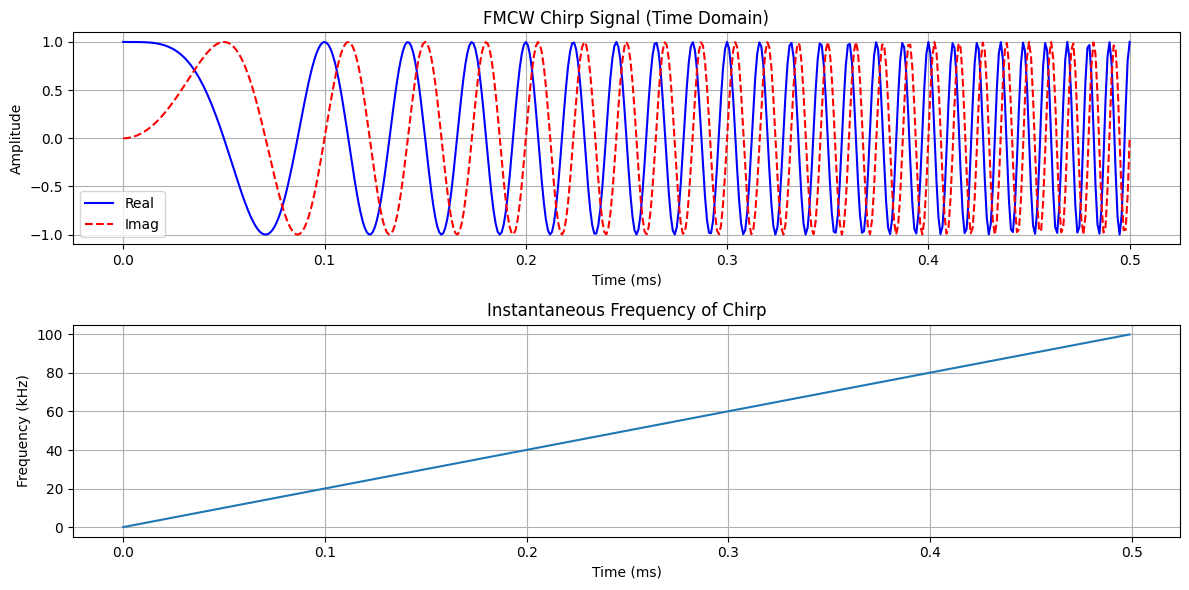

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sample_rate = 1e6
bw = 100e3
buffer_length = 4096

# Chirp generation
duration = 500e-6
ts = 1 / sample_rate
N_chirp = int(duration * sample_rate)
t = np.arange(0, N_chirp * ts, ts)
f_start, f_stop = 0, bw

chirp = np.exp(1j * 2 * np.pi * (f_start * t + 0.5 * (f_stop - f_start) / duration * t**2)).astype(np.complex64)

# Pad
chirp_padded = np.zeros(buffer_length, dtype=np.complex64)
chirp_padded[:len(chirp)] = chirp

# Plot real, imag, and instantaneous frequency
plt.figure(figsize=(12, 6))

# Real & Imag
plt.subplot(2, 1, 1)
plt.plot(t * 1e3, np.real(chirp), label='Real', color='b')
plt.plot(t * 1e3, np.imag(chirp), label='Imag', color='r', linestyle='--')
plt.title("FMCW Chirp Signal (Time Domain)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Instantaneous frequency (derivative of phase)
inst_phase = np.unwrap(np.angle(chirp))
inst_freq = np.diff(inst_phase) / (2 * np.pi * ts)
plt.subplot(2, 1, 2)
plt.plot(t[:-1] * 1e3, inst_freq / 1e3)
plt.title("Instantaneous Frequency of Chirp")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (kHz)")
plt.grid(True)

plt.tight_layout()
plt.show()
